# Unpaired data loading
> Loading of the dataset into the fastai `DataLoaders` class.

In [1]:
#default_exp data.unpaired

In [2]:
#export
from fastai.vision.all import *
from fastai.basics import *
from typing import List
from fastai.vision.gan import *

In [3]:
#hide
from nbdev.showdoc import *

## Example Dataset - Horse to Zebra conversion

Here, we are going to use the `horse2zebra` dataset provided by UC Berkeley. I have already downloaded it, You can download it at the URL https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip with the fastai `untar_data` function. Additionally, we can view the directory with `Path.ls()` (added by fastai).

In [4]:
horse2zebra = Path('../data/horse2zebra')

In [5]:
folders = horse2zebra.ls().sorted()
print(folders)

[Path('../data/horse2zebra/testA'), Path('../data/horse2zebra/testB'), Path('../data/horse2zebra/trainA'), Path('../data/horse2zebra/trainB')]


We can see that we have four directories, a train and test directory for both domains.

## Create DataLoaders object:

We can treat the image in Domain A as the input and the image in Domain B as the target. We want to be able to index the dataset for a fixed image in domain A but a random image in domain B, in order to avoid fixed pairs. 

A brief summary of how fastai Datasets works: 
> "A Datasets creates a tuple from items (typically input,target) by applying to them each list of Transform (or Pipeline) in tfms."

(from [docs](http://dev.fast.ai/data.core#Datasets))

So for transforms we will have a list of list of transforms. Each list of transforms are used to obtain, process, and return the inputs (in this case Domain A) and the targets (Domain B) as a tuple.

Let's first get our image paths:

In [6]:
trainA_path = folders[2]
trainB_path = folders[3]
testA_path = folders[0]
testB_path = folders[1]

We can use `get_image_files` to get the image files from the directories:

In [7]:
filesA = get_image_files(trainA_path)
filesB = get_image_files(trainB_path)

In [8]:
filesA

(#1067) [Path('../data/horse2zebra/trainA/n02381460_1001.jpg'),Path('../data/horse2zebra/trainA/n02381460_1002.jpg'),Path('../data/horse2zebra/trainA/n02381460_1003.jpg'),Path('../data/horse2zebra/trainA/n02381460_1006.jpg'),Path('../data/horse2zebra/trainA/n02381460_1008.jpg'),Path('../data/horse2zebra/trainA/n02381460_1009.jpg'),Path('../data/horse2zebra/trainA/n02381460_1011.jpg'),Path('../data/horse2zebra/trainA/n02381460_1014.jpg'),Path('../data/horse2zebra/trainA/n02381460_1019.jpg'),Path('../data/horse2zebra/trainA/n02381460_102.jpg')...]

Now, we can have a Transform that randomly selects an image in domain B for the current pair:

In [9]:
#export
class RandPair(Transform):
    "Returns a random image from domain B, resulting in a random pair of images from domain A and B."
    def __init__(self,itemsB): self.itemsB = itemsB
    def encodes(self,i): return random.choice(self.itemsB)

In [10]:
show_doc(RandPair, default_cls_level=3)

<h3 id="RandPair" class="doc_header"><code>class</code> <code>RandPair</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>RandPair</code>(**`itemsB`**) :: `Transform`

Returns a random image from domain B, resulting in a random pair of images from domain A and B.

In [11]:
test_ne(RandPair(filesB)(0),RandPair(filesB)(0))
test_eq(type(RandPair(filesB)(0)),type(Path('.')))

Now let's make our `Datasets` (assume no split for now). We load as a `PILImage`, convert to a `Tensor`, and resize:

In [13]:
size=128
dsets = Datasets(filesA, tfms=[[PILImage.create, ToTensor, Resize(size)], 
                               [RandPair(filesB),PILImage.create, ToTensor, Resize(size)]],splits=None)

Now  we can create a `DataLoader`. Note that fastai allows for batch-level transforms that can be performed on an accelerator like a GPU. Let's normalize the dataset:

In [14]:
batch_tfms = [IntToFloatTensor, Normalize.from_stats(mean=0.5, std=0.5)]
dls = dsets.dataloaders(bs=4, num_workers=2, after_batch=batch_tfms)

We can also show the batch:

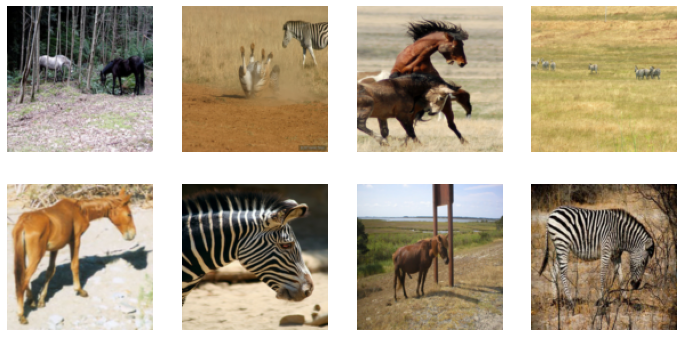

In [16]:
dls.show_batch()

In [15]:
xb,yb = dls.one_batch()
xb.shape

torch.Size([4, 3, 128, 128])

In [ ]:
plt.imshow(dls.after_batch.decode(xb)[0].cpu().permute(1,2,0).numpy())

Some hacks for custom normalization for each of the inputs.

In [17]:
#export
class TensorImage_(TensorImage): pass

In [18]:
#export
class ToTensor_(Transform):
    "Convert item to appropriate tensor class"
    order = 5
    def encodes(self, o:PILImage): return TensorImage_(image2tensor(o))

In [19]:
#export
class CustomNormalize(DisplayedTransform):
    "Normalize/denorm batch"
    parameters,order = L('mean', 'std', 'mean_', 'std_'),99
    def __init__(self, mean, std, mean_, std_, axes=(0,2,3)): store_attr()

    def encodes(self, x:TensorImage): 
        return (x-self.mean) / self.std
    
    def decodes(self, x:TensorImage):
        f = to_cpu if x.device.type=='cpu' else noop
        return (x*f(self.std) + f(self.mean))
    
    def encodes(self, x:TensorImage_): 
        return (x-self.mean_) / self.std_
    
    def decodes(self, x:TensorImage_):
        f = to_cpu if x.device.type=='cpu' else noop
        return (x*f(self.std_) + f(self.mean_))
    _docs=dict(encodes="Normalize batch", decodes="Denormalize batch")

Let's add a data loading function to our library. Note that we don't have a validation set (not necessary for CycleGAN training). Also note that we load the images with size `load_size` and take a random crop of the image with size `crop_size` (default of 256x256) to load into the model. We can also specify a subset of the data if we want (`num_A` and `num_B`). Finally, we have provided an optional argument to add your own transforms if you need.

In [20]:
#export
def get_dls(pathA, pathB, num_A=None, num_B=None, load_size=512, crop_size=256, item_tfms=None, batch_tfms=None, bs=4, num_workers=2, normalize=False):
    """
    Given image files from two domains (`pathA`, `pathB`), create `DataLoaders` object.
    Loading and randomly cropped sizes of `load_size` and `crop_size` are set to defaults of 512 and 256.
    Batch size is specified by `bs` (default=4).
    """
    filesA = get_image_files(pathA)
    filesB = get_image_files(pathB)
    filesA = filesA[:min(ifnone(num_A, len(filesA)),len(filesA))]
    filesB = filesB[:min(ifnone(num_B, len(filesB)),len(filesB))]

    if item_tfms is None: item_tfms = [Resize(load_size), RandomCrop(crop_size)]
    
    dsets = Datasets(filesA, tfms=[[PILImage.create, ToTensor, *item_tfms],
                                   [RandPair(filesB),PILImage.create, ToTensor_, *item_tfms]], splits=None)
    
    _batch_tfms = [IntToFloatTensor]
    if batch_tfms is None:
        if normalize == True:
            x = IntToFloatTensor()(torch.cat([torch.unsqueeze(i[0],0) for i in dsets]))
            mean,std = x.mean((0,2,3), keepdim=True),x.std((0,2,3), keepdim=True)+1e-7
            x_ = IntToFloatTensor()(torch.cat([torch.unsqueeze(i[1],0) for i in dsets]))
            mean_,std_ = x.mean((0,2,3), keepdim=True),x.std((0,2,3), keepdim=True)+1e-7          
            normalize_tfm = CustomNormalize(mean,std,mean_,std_)
        
        else: normalize_tfm = Normalize.from_stats(mean=0.5, std=0.5)
            
        batch_tfms = [normalize_tfm, FlipItem(p=0.5)]
    
    _batch_tfms = _batch_tfms + batch_tfms

    dls = dsets.dataloaders(bs=bs, num_workers=num_workers, after_batch=_batch_tfms)

    return dls

### Quick tests:

In [21]:
load_size=512
crop_size=256
bs=4
dls = get_dls(trainA_path, trainB_path,load_size=load_size,crop_size=crop_size,bs=bs)

In [22]:
test_eq(type(dls[0]),TfmdDL)
test_eq(len(dls[0]),int(len(trainA_path.ls())/bs))
test_eq(len(dls[1]),0)

In [23]:
xb,yb = next(iter(dls[0]))
test_eq(xb.shape,yb.shape)
test_eq(xb.shape,torch.Size([bs, 3, crop_size, crop_size]))

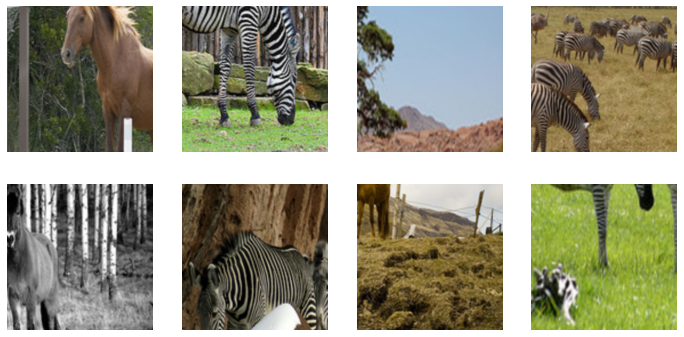

In [24]:
dls.show_batch()

In [25]:
num_A = 100
num_B = 150
dls = get_dls(trainA_path, trainB_path,num_A=num_A,num_B=num_B,load_size=load_size,crop_size=crop_size,bs=bs)

In [26]:
test_eq(len(dls[0]),int(min(num_A,num_B)/bs))

In [27]:
dls = get_dls(trainA_path, trainB_path,num_A=num_A,num_B=num_B,load_size=load_size,crop_size=crop_size, 
              batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(mean=0.5, std=0.5)], bs=bs)

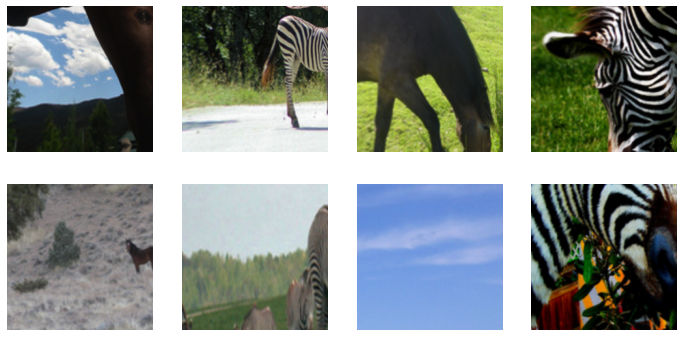

In [28]:
dls.show_batch()

In [29]:
from fastai.data.all import *

In [30]:
dls = get_dls(trainA_path, trainB_path,num_A=num_A,num_B=num_B,load_size=load_size,crop_size=crop_size, normalize=True, bs=bs)

Could not do one pass in your dataloader, there is something wrong in it


In [31]:
dls._one_pass()

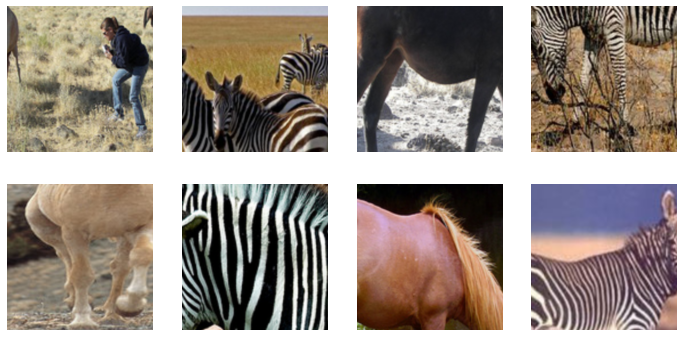

In [32]:
dls.show_batch()

In [33]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_models.cyclegan.ipynb.
Converted 01b_models.junyanz.ipynb.
Converted 02_data.unpaired.ipynb.
Converted 03_train.cyclegan.ipynb.
Converted 04_inference.cyclegan.ipynb.
Converted 05_metrics.ipynb.
Converted 06_tracking.wandb.ipynb.
Converted 07_models.dualgan.ipynb.
Converted 08_train.dualgan.ipynb.
Converted 09_models.ganilla.ipynb.
Converted index.ipynb.
